# Make figure for MPAS-O and ROMS Kinetic Energy Time Series and Spectra

In [ ]:
import xarray as xr
import xroms
import xgcm
from xhistogram.xarray import histogram

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os
import time

from scipy import signal

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import dask
from dask.distributed import Client

client = Client()
client

## Load MPAS-O data

In [6]:
mroots = [
         '/mpaso_channel/10km/',
         '/mpaso_channel/5km/',
         '/mpaso_channel/2km/',
         '/mpaso_channel/1km/',
         '/mpaso_channel/500m/',    
         '/mpaso_channel/200m/',
         '/mpaso_channel/100m/'
]

In [7]:
mds = []
mdsg = []
mverts = []
midx = []
mnorm = []
for rootdir in mroots:
    ds_mpas = xr.open_dataset(rootdir + 'output.nc', chunks={'Time': 1})
    dsg = xr.open_dataset(rootdir + 'channel_init.nc')
    ds_mpas['normalizedRelativeVorticity'] = ds_mpas.relativeVorticityCell / dsg.fCell
    ds_mpas['normalizedDivergence'] = ds_mpas.divergence / dsg.fCell
    mds.append(ds_mpas)
    mdsg.append(dsg)

    verts = np.dstack((dsg.xVertex.values[dsg.verticesOnCell-1],
                       dsg.yVertex.values[dsg.verticesOnCell-1]))
    nverts = np.sum(dsg.verticesOnCell != 0, axis=1).values
    verts = [vert[:n] for vert, n in zip(verts, nverts)]
    idx = [(np.abs(vert[:, 0].ptp()) < 50000) for vert in verts]
    midx.append(idx)
    verts = np.array(verts)[idx]
    mverts.append(verts)

    norm = plt.matplotlib.colors.Normalize(-3, 3)
    mnorm.append(norm)

In [8]:
res_lgd = ['10 km', '5 km', '2 km', '1 km', '500 m', '200 m']

### Calculate surface KE for MPAS-O

In [ ]:
# Loop over MPAS-O outputs and calculate average KE from variable kineticEnergyCell

mkes = []
for axi in range(len(mds)):
    ympas = mdsg[axi].yCell.values
    # Only calculate kinetic energy 50 km away from the walls of the model domain
    idx = np.where(np.logical_and(ympas>50000, ympas<250000))
    mpas_ke = mds[axi].kineticEnergyCell.isel(
                nVertLevels=0, nCells=slice(idx[0][0], idx[0][-1])).mean(dim='nCells').compute()
    mkes.append(mpas_ke)


In [ ]:
rainbow_cmap = np.asarray([[165,0,38],
                         [215,48,39],
                         [253,174,97],
                         [0,0,0],
                         [171,217,233],
                         [116,173,209],
                         [49,54,149]]) / 255


Text(0.5, 1.0, 'MPAS-O')

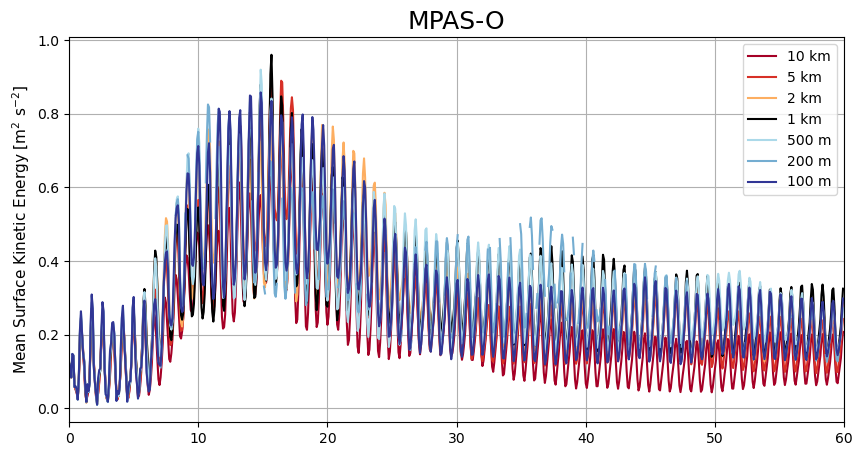

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ndays = 60
tsteps = ndays * 12

t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))

for iplot in range(len(mkes)):
    if iplot==5:
        mpas_ke = mkes[iplot]
    elif iplot!=5:
        mpas_ke = mkes[iplot] #/ 1025
    ax.plot(t[0:len(mpas_ke)], mpas_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[iplot,:])

ax.set_xlim(0, 60)
ax.grid(True)

ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=11)
ax.legend(loc='upper right')
ax.set_title('MPAS-O', fontsize=18, loc='center')


## Load ROMS data

In [ ]:
roms_files = [
         '/roms_channel/10km/roms_his.nc',
         '/roms_channel/5km/roms_his.nc',
         '/roms_channel/2km/roms_his.nc',
         '/roms_channel/1km/roms_his.nc',
         '/roms_channel/500m/roms_his.nc',
         '/roms_channel/200m/roms_his.nc',
         '/roms_channel/100m/roms_his.nc',
        ]


In [66]:
# Load and calculate kinetic energy for ROMS datasets using xroms

dss = []
for file in roms_files:
    ds = xr.open_dataset(file, chunks={'ocean_time': 1})
    ds, xgrid = xroms.roms_dataset(ds)
    speed = xroms.speed(ds.u, ds.v, xgrid)
    KE = xroms.KE(ds.rho0, speed)
    ds['ke'] = KE
    ds = ds.isel(s_rho=-1)
    dss.append(ds)

### Calculate average ROMS surface kinetic energy values for all resolutions

In [10]:
ke_roms = []

for axi in range(len(dss)):
    # Only calculate kinetic energy 50 km away from the walls of the model domain
    conditional = (dss[axi].y_rho > 50e3) & (dss[axi].y_rho < 250e3)
    grab_ke = dss[axi].ke.where(conditional)
    calc_ke = grab_ke.mean(dim=['xi_rho', 'eta_rho']).compute()

    ke_roms.append(calc_ke)

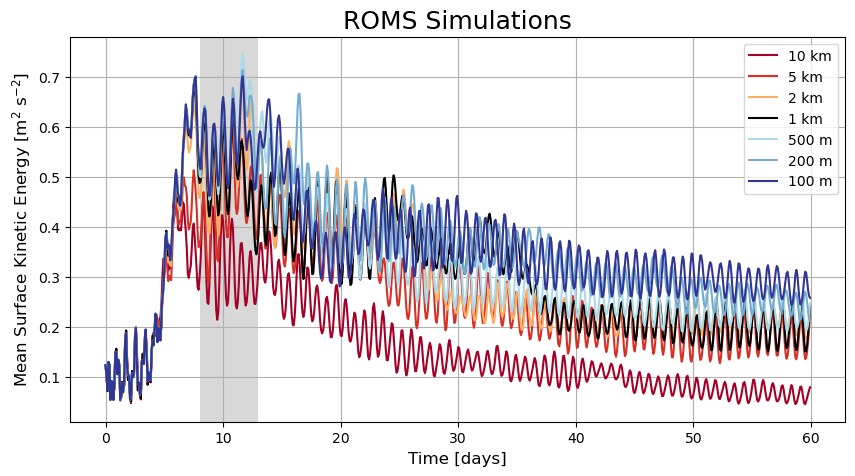

In [80]:
### ROMS Kinetic Energy Plot

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ndays = 60
tsteps = ndays * 12
t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
for iplot in range(len(ke_roms)):
    roms_grab = ke_roms[iplot] / dss[0].rho0.values
    ax.plot(t[0:len(roms_grab)], roms_grab[:tsteps],
            label=res_lgd[iplot], color=rainbow_cmap[iplot,:])
ax.grid(True)
ax.set_xlabel('Time [days]', fontsize=12)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=12)
ax.legend(loc='upper right')
ax.set_title('ROMS Simulations', fontsize=18, loc='center')
ax.axvspan(8, 13, color='grey', alpha=0.3, lw=0) # Highlight 5-day region of maximum KE

## Plot combined ROMS and MPAS plots

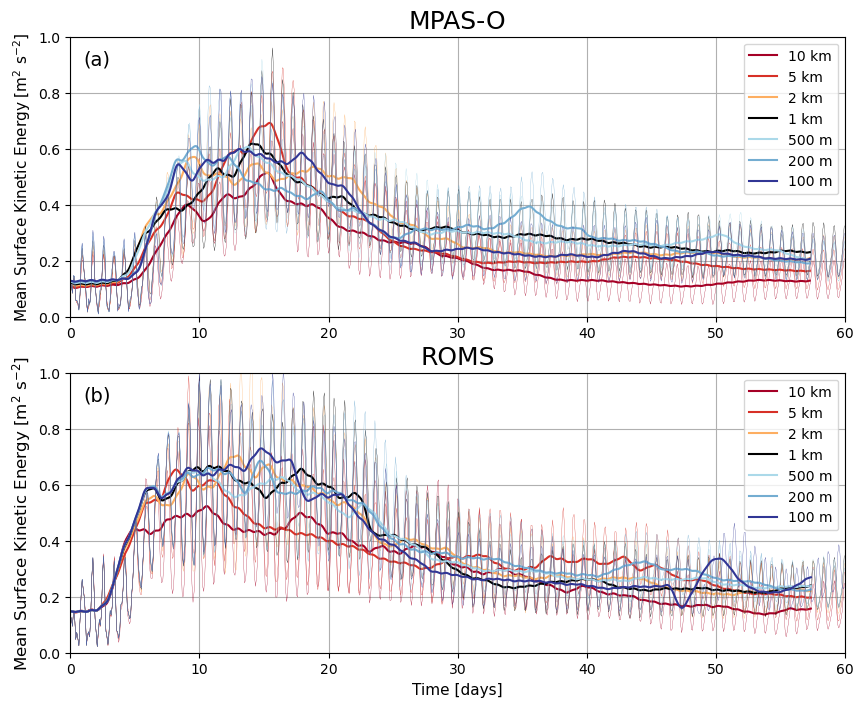

In [ ]:
fig = plt.figure(figsize=(10, 8))

ndays = 60
tsteps = ndays * 12

### MPAS-O Plot
ax = fig.add_subplot(211)

t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
icolor = 0
for iplot in range(len(mkes)):
    mpas_ke = pl33tn(mkes[iplot], dt=2)
    ax.plot(t[0:len(mpas_ke)], mpas_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[icolor,:])
    raw_mkes = mkes[iplot]
    ax.plot(t[0:len(raw_mkes)], raw_mkes[:tsteps], label='', linewidth=0.2,
           color=rainbow_cmap[icolor,:])
    icolor+=1
ax.set_ylim(0, 1.0)
ax.set_xlim(0, 60)
ax.grid(True)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=11)
ax.legend(loc='upper right')
ax.set_title('MPAS-O', fontsize=18, loc='center')
plt.text(1, 0.9, '(a)', fontsize=14)

### ROMS Plot
ax = fig.add_subplot(212)

ndays = 60
tsteps = ndays * 12

t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
icolor = 0
for iplot in range(len(ke_roms)):
    roms_ke = pl33tn(ke_roms[iplot]/1025, dt=2)
    ax.plot(t[0:len(roms_ke)], roms_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[icolor,:])
    raw_rke = ke_roms[iplot]/1025
    ax.plot(t[0:len(raw_rke)], raw_rke[:tsteps], label='', linewidth=0.2,
       color=rainbow_cmap[icolor,:])
    icolor+=1

ax.set_ylim(0, 1.0)
ax.set_xlim(0, 60)
ax.grid(True)
ax.set_xlabel('Time [days]', fontsize=11)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=12)
ax.legend(loc='upper right')
ax.set_title('ROMS', fontsize=18, loc='center')
plt.text(1, 0.9, '(b)', fontsize=14)



## Add in Power Spectral Densities

In [ ]:
### MPAS-O Power Densities

f_mpas = []
pden_mpas = []

for rds in mkes:
    cell_len = len(rds.nCells)
    f_arr = np.zeros((129, cell_len))
    pden_arr = np.zeros((129, cell_len))

    ke_grab = rds.values

    for i in range(cell_len):
        bb = ke_grab[:,i]
        f0, Pxx_den0 = signal.welch(bb, 12)
        f_arr[:,i] = f0
        pden_arr[:,i] = Pxx_den0

    f_mpas.append(f_arr.mean(axis=1))
    pden_mpas.append(pden_arr.mean(axis=1))

In [ ]:
### ROMS Power Densities

f_roms = []
pden_roms = []

for rds in dss:
    xi_len = len(rds.xi_rho)
    eta_len = len(rds.eta_rho)
    f_arr = np.empty((129, eta_len, xi_len))
    pden_arr = np.empty((129, eta_len, xi_len))
    f_arr[:] = np.nan
    pden_arr[:] = np.nan

    conditional = (rds.y_rho > 50e3) & (rds.y_rho < 250e3)
    ke_grab = rds.ke.where(conditional).values

    for i in range(xi_len):
        for j in range(eta_len):
            f0, Pxx_den0 = signal.welch((ke_grab[:,j,i]/1025), 12)
            f_arr[:,j,i] = f0
            pden_arr[:,j,i] = Pxx_den0


    f_roms.append(np.nanmean(f_arr, axis=(1, 2)))
    pden_roms.append(np.nanmean(pden_arr, axis=(1, 2)))

## Make Final Figure 4 Plot

In [ ]:
# Highlight 1 km resolution simulation, make other resolutions lighter in color
pinkcolor = np.divide([254, 204, 204], 255)
greycolor = np.divide([207, 207, 207], 255)
pinkcolor = [1, 0.8, 0.8]
greycolor = [0.8, 0.8, 0.8]

In [ ]:
# Calculate frequency of wind forcing and add to plot
windfrc = 1E-4/(2*np.pi)*86400
wf_line = windfrc*0.9
f_line = windfrc

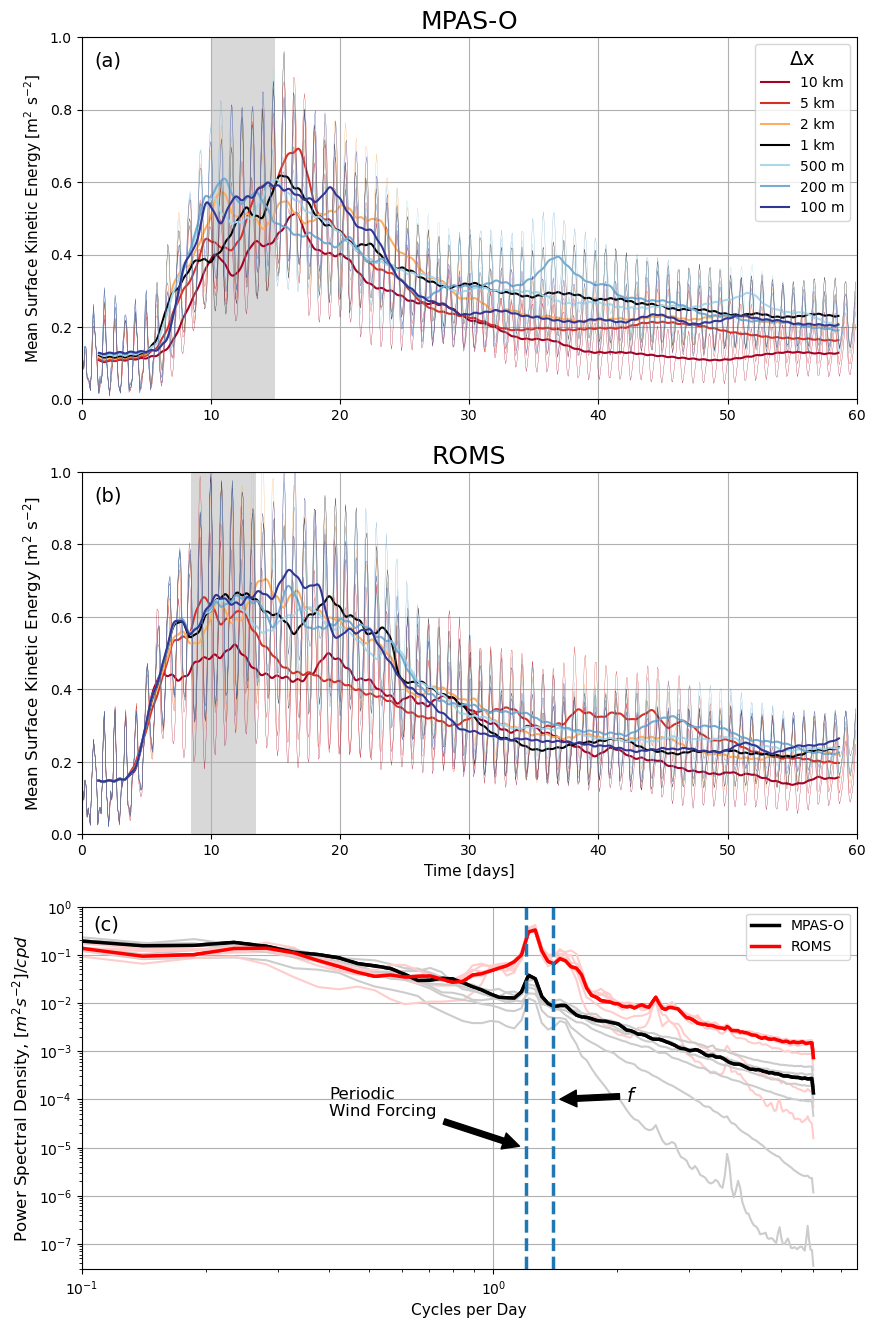

In [ ]:
fig = plt.figure(figsize=(10, 16))

ndays = 60
tsteps = ndays * 12

#-----------------------------------------------------------------------------#
ax = fig.add_subplot(311) # MPAS-O Kinetic Energy Time Series

t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
icolor = 0
for iplot in range(len(mkes)):
    mpas_ke = pl33tn(mkes[iplot], dt=2)
    tadjust = (len(t) - len(mpas_ke)) / 24
    ax.plot(t[0:len(mpas_ke)]+tadjust, mpas_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[icolor,:])
    raw_mkes = mkes[iplot]
    ax.plot(t[0:len(raw_mkes)], raw_mkes[:tsteps], label='', linewidth=0.2,
           color=rainbow_cmap[icolor,:])
    icolor+=1
ax.set_ylim(0, 1.0)
ax.set_xlim(0, 60)
ax.grid(True)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=11)
l1 = ax.legend(loc='upper right', title='$\Delta$x')
l1.get_title().set_fontsize('14')
ax.set_title('MPAS-O', fontsize=18, loc='center')
plt.text(1, 0.92, '(a)', fontsize=14)
ax.axvspan(10, 15, color='grey', alpha=0.3, lw=0)

#-----------------------------------------------------------------------------#
ax = fig.add_subplot(312) # ROMS Kinetic Energy Time Series

t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
icolor = 0
for iplot in range(len(ke_roms)):
    roms_ke = pl33tn(ke_roms[iplot]/1025, dt=2)
    tadjust = (len(t) - len(roms_ke)) / 24
    ax.plot(t[0:len(roms_ke)]+tadjust, roms_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[icolor,:])
    raw_rke = ke_roms[iplot]/1025
    ax.plot(t[0:len(raw_rke)], raw_rke[:tsteps], label='', linewidth=0.2,
       color=rainbow_cmap[icolor,:])
    icolor+=1
ax.set_ylim(0, 1.0)
ax.set_xlim(0, 60)
ax.grid(True)
ax.set_xlabel('Time [days]', fontsize=11)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=12)
ax.set_title('ROMS', fontsize=18, loc='center')
plt.text(1, 0.92, '(b)', fontsize=14)
ax.axvspan(8.5, 13.5, color='grey', alpha=0.3, lw=0)

#-----------------------------------------------------------------------------#
ax = fig.add_subplot(313) # Spectral Density Plot
ax.loglog(mpas_fs[4], mpas_pden[4], 'k', label='MPAS-O', linewidth=2.5) # Highlight MPAS-O 1 km resolution run
ax.loglog(roms_fs[4], roms_pden[4], 'r', label='ROMS', linewidth=2.5) # Highlight ROMS 1 km resolution run
for i in range(len(res_lgd)):
    if i==4:
        continue
    else:
        ax.loglog(mpas_fs[i], mpas_pden[i], color=greycolor)
        ax.loglog(roms_fs[i], roms_pden[i], color=pinkcolor)

ax.loglog(mpas_fs[4], mpas_pden[4], 'k', linewidth=2.5) # repeated here to place 1 km on top and work with legend order
ax.loglog(roms_fs[4], roms_pden[4], 'r', linewidth=2.5) # repeated here to place 1 km on top and work with legend order
ax.axvline(wf_line, linewidth=2.5, linestyle='--') # Wind forcing
ax.axvline(f_line, linewidth=2.5, linestyle='--') # Coriolis term

ax.annotate('Periodic\nWind Forcing', xy=(wf_line-0.05, 1E-5), xytext=(0.4, 4.5E-5),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
ax.annotate('$f$', xy=(f_line+0.05, 1E-4), xytext=(2.1, 9E-5),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)
ax.set_xlim(left=1e-1)
ax.set_ylim([3e-8, 1E0])
ax.set_xlabel('Cycles per Day', fontsize=11)
ax.set_ylabel(r'Power Spectral Density, $[m^2 s^{-2}]/cpd$', fontsize=12)
ax.legend()
ax.grid()
plt.text(1.07E-1, 3.2E-1, '(c)', fontsize=14)



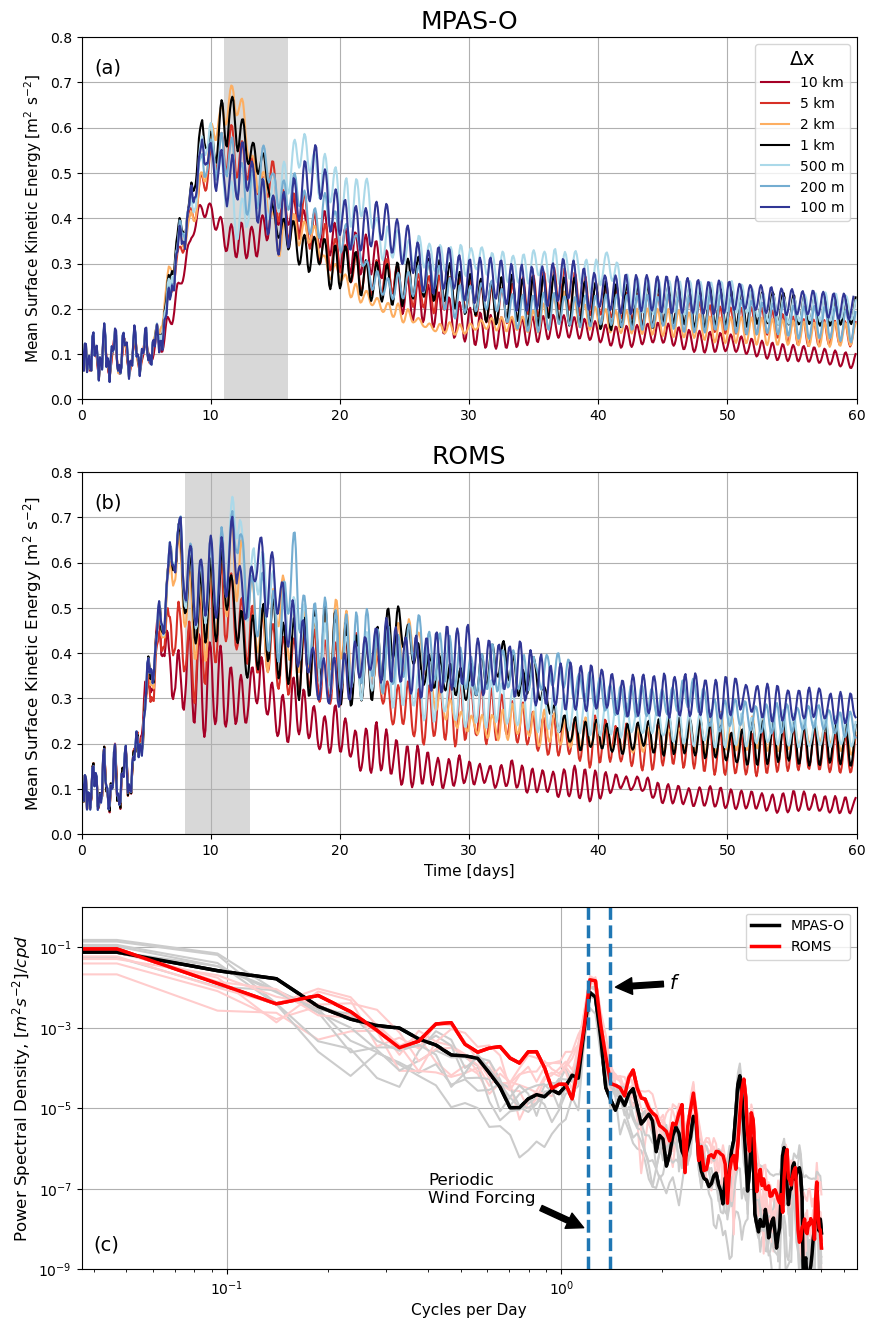

In [ ]:
fig = plt.figure(figsize=(10, 16))

#-----------------------------------------------------------------------------#
ax = fig.add_subplot(311) # MPAS-O Kinetic Energy Time Series

ndays = 60
tsteps = ndays * 12

t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
icolor = 0
for iplot in range(len(mkes)):
    mpas_ke = mkes[iplot]
    ax.plot(t[0:len(mpas_ke)], mpas_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[icolor,:])
    icolor+=1
ax.set_ylim(0, 0.8)
ax.set_xlim(0, 60)
ax.grid(True)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=11)
l1 = ax.legend(loc='upper right', title='$\Delta$x')
l1.get_title().set_fontsize('14')
ax.set_title('MPAS-O', fontsize=18, loc='center')
plt.text(1, 0.72, '(a)', fontsize=14)
ax.axvspan(11, 16, color='grey', alpha=0.3, lw=0)

#-----------------------------------------------------------------------------#
ax = fig.add_subplot(312) # ROMS Kinetic Energy Time Series

ndays = 60
tsteps = ndays * 12

t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
icolor = 0
for iplot in range(len(ke_roms)):
    roms_ke = ke_roms[iplot] / dss[0].rho0.values
    ax.plot(t[0:len(roms_ke)], roms_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[icolor,:])
    icolor+=1
ax.set_ylim(0, 0.8)
ax.set_xlim(0, 60)
ax.grid(True)
ax.set_xlabel('Time [days]', fontsize=11)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=12)
ax.set_title('ROMS', fontsize=18, loc='center')
plt.text(1, 0.72, '(b)', fontsize=14)
ax.axvspan(8, 13, color='grey', alpha=0.3, lw=0)

#-----------------------------------------------------------------------------#
ax = fig.add_subplot(313) # Spectral Density Plot

ax.loglog(mpas_fs[4], mpas_pden[4], 'k', label='MPAS-O', linewidth=2.5) # Highlight 1 km resolution run
ax.loglog(roms_fs[4], roms_pden[4], 'r', label='ROMS', linewidth=2.5) # Highlight 1 km resolution run
for i in range(len(res_lgd)):
    if i==4:
        continue
    else:
        ax.loglog(mpas_fs[i], mpas_pden[i], color=greycolor)
        ax.loglog(roms_fs[i], roms_pden[i], color=pinkcolor)

ax.loglog(mpas_fs[4], mpas_pden[4], 'k', linewidth=2.5) # repeated here to place 1 km on top and work with legend order
ax.loglog(roms_fs[4], roms_pden[4], 'r', linewidth=2.5) # repeated here to place 1 km on top and work with legend order
ax.axvline(wf_line, linewidth=2.5, linestyle='--') # Wind forcing
ax.axvline(f_line, linewidth=2.5, linestyle='--') # Coriolis term

ax.annotate('Periodic\nWind Forcing', xy=(wf_line-0.05, 1E-8), xytext=(0.4, 4.5E-8),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
ax.annotate('$f$', xy=(f_line+0.05, 1E-2), xytext=(2.1, 9E-3),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)
ax.set_ylim([1e-9, 1E0])
ax.set_xlabel('Cycles per Day', fontsize=11)
ax.set_ylabel(r'Power Spectral Density, $[m^2 s^{-2}]/cpd$', fontsize=12)
ax.legend()
ax.grid()
plt.text(4E-2, 3E-9, '(c)', fontsize=14)
